In [52]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


In [8]:
evaluaciones = pd.read_csv('evaluaciones_2022.csv', delimiter=',')
evaluaciones.head()

,FECHA_EVALUACION,TX_SEXO,NU_EDAD,TX_PROVINCIA,TX_TIPO_CLIENTE,TX_ESTADO_EVALUACION_DWH,TX_CANAL_ORIGINAL,VL_INGRESO_NOSIS,VL_SCORE_NOSIS,VL_DESEMBOLSADO,VL_CUOTA,VL_TASA,CD_CAJON_MORA,NU_CUOTA_PAGADAS,NU_CUOTAS_EN_MORA,CD_SUBESTADO_PRODUCTO,NU_DIAS_MORA
0,20220110,FEMENINO,69,BUENOS AIRES,EXISTENTE,RECHAZADA,WHATSAPP,0,0.0,0.0,0.0,0.0,0.0,14,0,CANCELADO,0.0
1,20220119,MASCULINO,68,CAPITAL FEDERAL,EXISTENTE,RECHAZADA,API,0,0.0,0.0,0.0,0.0,0.0,14,0,CANCELADO,0.0
2,20220127,MASCULINO,65,CAPITAL FEDERAL,EXISTENTE,RECHAZADA,API,0,0.0,0.0,0.0,0.0,0.0,13,1,EXTRACONTABLE,0.0
3,20220119,MASCULINO,58,CAPITAL FEDERAL,EXISTENTE,RECHAZADA,API,0,0.0,0.0,0.0,0.0,0.0,14,0,CANCELADO,0.0
4,20220119,FEMENINO,56,CAPITAL FEDERAL,CONOCIDO,RECHAZADA,API,0,0.0,0.0,0.0,0.0,0.0,14,0,CANCELADO,0.0


#### CALCULO de APPROVAL: Agrupada por Canal
Previo a Depurar Datos:

In [9]:
grupo_canal_estado = evaluaciones.groupby(['TX_CANAL_ORIGINAL', 'TX_ESTADO_EVALUACION_DWH']).size().unstack()
grupo_canal_estado['% Aprobada'] = (grupo_canal_estado['APROBADA'] / grupo_canal_estado.sum(axis=1)) * 100
grupo_canal_estado

TX_ESTADO_EVALUACION_DWH,APROBADA,RECHAZADA,% Aprobada
TX_CANAL_ORIGINAL,,,
0,NaN,5.0,NaN
API,67645.0,383223.0,15.003283
SAC,4910.0,6026.0,44.897586
SAC CBU,3037.0,1794.0,62.864831
SUCURSAL,1017814.0,486648.0,67.653021
TELEFONICO,8633.0,152.0,98.269778
TELEMARKETING,43730.0,37653.0,53.733581
TLMK CBU,15288.0,346.0,97.786875
WEB,20206.0,109050.0,15.632543


#### Conclusión:
* API y WEB, poseen el 15% de Approval, se refiere a clientes que se autogentionan, por los canales NO presenciales sin intervención Humana.
* TELEFONICO y TLMK CBU, con el mayor % de Approval, corresponde a solicitudes Finalizadas de por telefono por parte de la sucursal, en tiempo real, de forma reactiva al cliente.
* TELEMARKETING, con el 53% gestiones telefonicas, mayormente enfocadas en cliente conocidos.
* WHATSAPP, de la misma manera que API/WEB, corresponde a la atención NO presencial, pero con una convinación Hibrida, participando en la venta un humano.

El comportamiento de Pago Historico, fue moldeando los diferentes Approval para cada canal de contacto del cliente, definiendo que los canales NO PRESENCIALES, se corresponden a los canales de mayor riesgo de incobrabilidad.

---------------------

#### TRANSFORMACION del DATA SET:
* Eliminar de la Variables "CD_SUBESTADO_PRODUCTO" = CANCELADO
* Eliminar los registros identificados con "0" de la Variable "VL_INGRESO_NOSIS" y "NC".


In [10]:
evaluaciones = evaluaciones[evaluaciones['CD_SUBESTADO_PRODUCTO'] != 'CANCELADO']
evaluaciones = evaluaciones[evaluaciones['VL_INGRESO_NOSIS'] != '0']
evaluaciones = evaluaciones[evaluaciones['VL_INGRESO_NOSIS'] != 'NC']
evaluaciones = evaluaciones[~evaluaciones['CD_SUBESTADO_PRODUCTO'].isin(['ANULADO', 'EXTRACONTABLE', 'NO LIQUIDADO'])]
evaluaciones = evaluaciones.reset_index(drop=True)
evaluaciones

,FECHA_EVALUACION,TX_SEXO,NU_EDAD,TX_PROVINCIA,TX_TIPO_CLIENTE,TX_ESTADO_EVALUACION_DWH,TX_CANAL_ORIGINAL,VL_INGRESO_NOSIS,VL_SCORE_NOSIS,VL_DESEMBOLSADO,VL_CUOTA,VL_TASA,CD_CAJON_MORA,NU_CUOTA_PAGADAS,NU_CUOTAS_EN_MORA,CD_SUBESTADO_PRODUCTO,NU_DIAS_MORA
0,20220103,FEMENINO,73,CAPITAL FEDERAL,NUEVO,APROBADA,API,D2,342.0,0.00,0.00,0.00,0.0,10,2,WRITE OFF,0.0
1,20220112,FEMENINO,74,MISIONES,NUEVO,RECHAZADA,WEB,D1,57.0,0.00,0.00,0.00,0.0,12,13,WRITE OFF,0.0
2,20220120,FEMENINO,44,CAPITAL FEDERAL,NUEVO,RECHAZADA,API,D2,129.0,0.00,0.00,0.00,0.0,23,1,WRITE OFF,0.0
3,20220121,FEMENINO,76,BUENOS AIRES,NUEVO,RECHAZADA,SUCURSAL,D1,530.0,0.00,0.00,0.00,0.0,28,0,PROBLEMAS,0.0
4,20220120,MASCULINO,66,BUENOS AIRES,EXISTENTE,APROBADA,SUCURSAL,D1,262.0,60831.09,7840.69,83.95,0.0,11,7,NO DEFINIDO,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214351,20221221,FEMENINO,76,CORDOBA,NUEVO,APROBADA,WHATSAPP,D1,466.0,0.00,0.00,0.00,8.0,0,8,MORA > 90,221.0
214352,20221226,MASCULINO,40,SANTA FE,NUEVO,APROBADA,API,D2,1.0,50000.00,18902.34,299.06,8.0,0,8,MORA > 90,221.0
214353,20221226,FEMENINO,28,BUENOS AIRES,NUEVO,RECHAZADA,WHATSAPP,C2,190.0,0.00,0.00,0.00,8.0,0,9,MORA > 90,235.0
214354,20221229,FEMENINO,79,BUENOS AIRES,NUEVO,APROBADA,WHATSAPP,D1,286.0,0.00,0.00,0.00,5.0,3,6,MORA > 90,146.0


### ANALIZAR la Información del Data Set:

In [11]:
evaluaciones.count()

FECHA_EVALUACION            214356
TX_SEXO                     214356
NU_EDAD                     214356
TX_PROVINCIA                214356
TX_TIPO_CLIENTE             214356
TX_ESTADO_EVALUACION_DWH    214356
TX_CANAL_ORIGINAL           214356
VL_INGRESO_NOSIS            214356
VL_SCORE_NOSIS              214356
VL_DESEMBOLSADO             214356
VL_CUOTA                    214356
VL_TASA                     214356
CD_CAJON_MORA               214356
NU_CUOTA_PAGADAS            214356
NU_CUOTAS_EN_MORA           214356
CD_SUBESTADO_PRODUCTO       214356
NU_DIAS_MORA                214356
dtype: int64

In [12]:
evaluaciones['TX_ESTADO_EVALUACION_DWH'].value_counts()

TX_ESTADO_EVALUACION_DWH
APROBADA     152235
RECHAZADA     62121
Name: count, dtype: int64

In [13]:
evaluaciones['TX_CANAL_ORIGINAL'].value_counts()

TX_CANAL_ORIGINAL
SUCURSAL         141960
API               28660
WHATSAPP          26658
WEB                8429
TELEMARKETING      5692
TLMK CBU           1284
SAC                 738
TELEFONICO          577
SAC CBU             358
Name: count, dtype: int64

In [14]:
evaluaciones['CD_SUBESTADO_PRODUCTO'].describe()

count     214356
unique         7
top       AL DIA
freq      118277
Name: CD_SUBESTADO_PRODUCTO, dtype: object

In [15]:
rtdo_eval = evaluaciones['CD_SUBESTADO_PRODUCTO'].value_counts()  #Identificamos que el Estado "CANCELADO" Concentra la mayor cantidad de Registros
rtdo_eval

CD_SUBESTADO_PRODUCTO
AL DIA         118277
MORA > 90       65016
MORA < 90       21832
NO DEFINIDO      7676
WRITE OFF         881
PROBLEMAS         616
VENDIDO            58
Name: count, dtype: int64

In [16]:
evaluaciones['CD_SUBESTADO_PRODUCTO'].value_counts()

CD_SUBESTADO_PRODUCTO
AL DIA         118277
MORA > 90       65016
MORA < 90       21832
NO DEFINIDO      7676
WRITE OFF         881
PROBLEMAS         616
VENDIDO            58
Name: count, dtype: int64

##### Eliminar Ceros:

In [17]:
evaluaciones = evaluaciones[evaluaciones['TX_SEXO'] != '0']
evaluaciones = evaluaciones[evaluaciones['TX_CANAL_ORIGINAL'] != '0']

-----------------------------------------------------------------------------------------------------------------------------------------

### Agrupaciones:

#### Agrupar por Estado y Canal:

In [18]:
grupo_estado = evaluaciones.groupby(['TX_ESTADO_EVALUACION_DWH', 'TX_CANAL_ORIGINAL']).size().unstack()/100
grupo_estado = grupo_estado.fillna(0)
grupo_estado = grupo_estado.round(0)
grupo_estado['TOTAL'] = grupo_estado.sum(axis=1)
grupo_estado

TX_CANAL_ORIGINAL,API,SAC,SAC CBU,SUCURSAL,TELEFONICO,TELEMARKETING,TLMK CBU,WEB,WHATSAPP,TOTAL
TX_ESTADO_EVALUACION_DWH,,,,,,,,,,
APROBADA,141.0,4.0,2.0,1089.0,6.0,36.0,13.0,55.0,177.0,1523.0
RECHAZADA,146.0,4.0,1.0,330.0,0.0,21.0,0.0,30.0,90.0,622.0


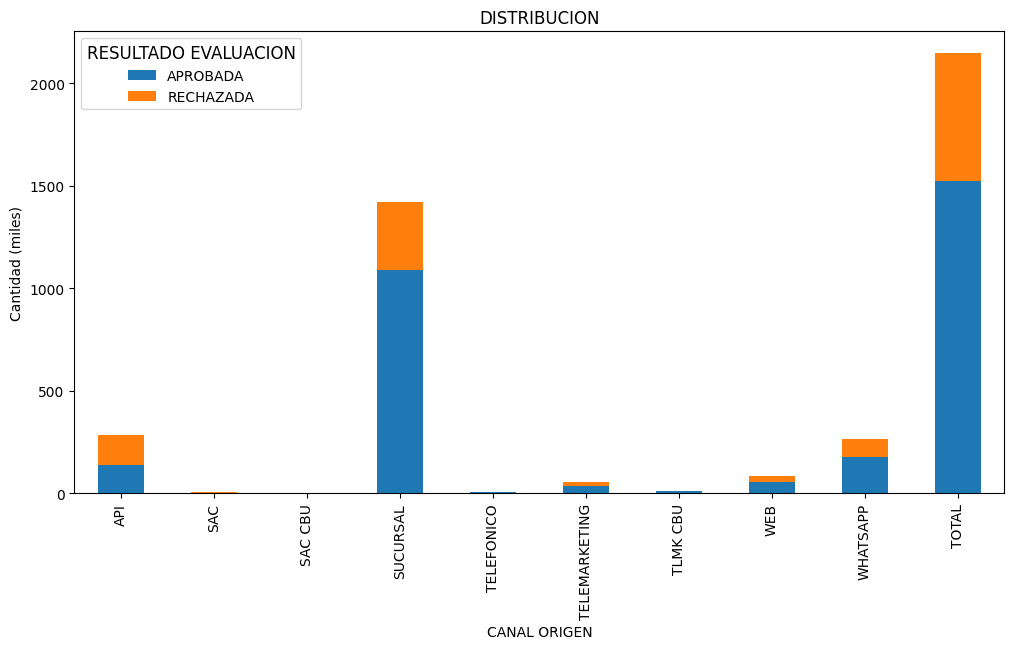

In [19]:
ax = grupo_estado.T.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('CANAL ORIGEN')
plt.ylabel('Cantidad (miles)')
plt.title('DISTRIBUCION')
plt.legend(title='RESULTADO EVALUACION', title_fontsize=12)
plt.show()

#### Agrupar por Estado y Tipo de Sexo:

In [20]:
grupo_sexo = evaluaciones.groupby(['TX_ESTADO_EVALUACION_DWH', 'TX_SEXO']).size().unstack()/100
grupo_sexo = grupo_sexo.fillna(0)
grupo_sexo = grupo_sexo.round(0)
grupo_sexo['TOTAL'] = grupo_sexo.sum(axis=1)

grupo_sexo

TX_SEXO,FEMENINO,MASCULINO,TOTAL
TX_ESTADO_EVALUACION_DWH,,,
APROBADA,950.0,572.0,1522.0
RECHAZADA,384.0,237.0,621.0


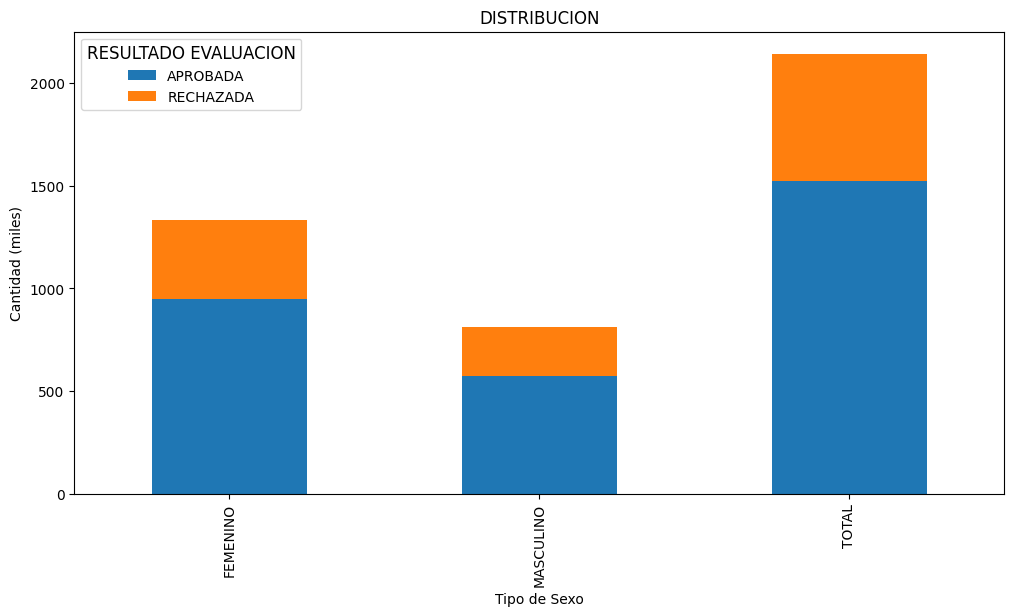

In [21]:
ax = grupo_sexo.T.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Tipo de Sexo')
plt.ylabel('Cantidad (miles)')
plt.title('DISTRIBUCION')
plt.legend(title='RESULTADO EVALUACION', title_fontsize=12)
plt.show()

#### Agrupar por Cajon de Mora y Tipo de Sexo:

In [22]:
grupo_cajon = evaluaciones.groupby(['CD_CAJON_MORA', 'TX_SEXO']).size().unstack()/1000
grupo_cajon = grupo_cajon.fillna(0)
grupo_cajon = grupo_cajon.round(0)
grupo_cajon

TX_SEXO,FEMENINO,MASCULINO
CD_CAJON_MORA,,
0.0,88.0,43.0
1.0,6.0,4.0
2.0,5.0,3.0
3.0,4.0,3.0
4.0,3.0,2.0
5.0,2.0,1.0
6.0,2.0,2.0
7.0,3.0,2.0
8.0,2.0,2.0


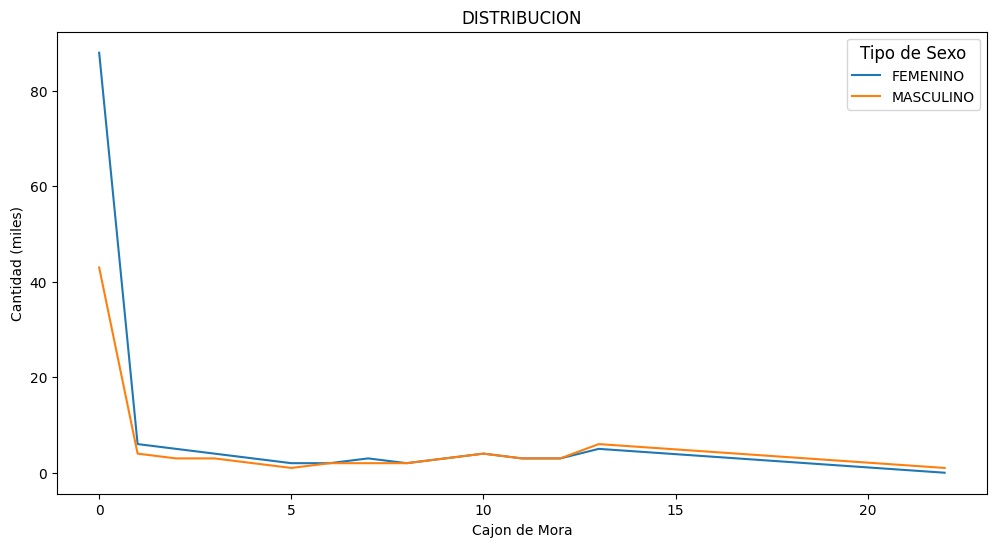

In [23]:
ax = grupo_cajon.plot(kind='line', figsize=(12, 6))
plt.xlabel('Cajon de Mora')
plt.ylabel('Cantidad (miles)')
plt.title('DISTRIBUCION')
plt.legend(title='Tipo de Sexo', title_fontsize=12)
plt.show()

##### Conclusión:
* Con este gráfico podemos observar una mayor cantidad de Clientes de Tipo Sexo Femenino en los primeros cajones de mora, es decir con un mejor comportamiento de pago.
* Observamos además que una vez alcanzado el cajon 5 se equilibran en cuanto a cantidad de clientes por sexo en cada "Cajón de Mora".

#### Agrupar por Cajon de Mora y Canal:

In [24]:
evaluaciones['TX_CANAL_ORIGINAL'].value_counts()

TX_CANAL_ORIGINAL
SUCURSAL         141945
API               28654
WHATSAPP          26638
WEB                8428
TELEMARKETING      5692
TLMK CBU           1284
SAC                 738
TELEFONICO          576
SAC CBU             358
Name: count, dtype: int64

In [25]:
grupo_canal = evaluaciones.groupby(['CD_CAJON_MORA', 'TX_CANAL_ORIGINAL']).size().unstack()/1000
grupo_canal = grupo_canal.fillna(0)
grupo_canal = grupo_canal.round(0)
grupo_canal

TX_CANAL_ORIGINAL,API,SAC,SAC CBU,SUCURSAL,TELEFONICO,TELEMARKETING,TLMK CBU,WEB,WHATSAPP
CD_CAJON_MORA,,,,,,,,,
0.0,9.0,1.0,0.0,101.0,0.0,3.0,1.0,3.0,12.0
1.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,1.0
2.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0
3.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0
4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
5.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
6.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
7.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
8.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0


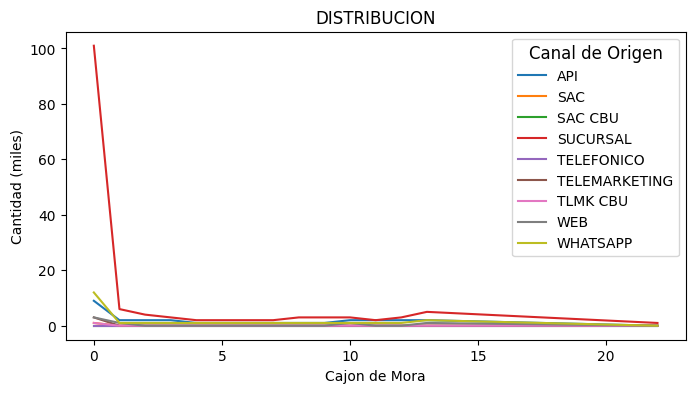

In [26]:
ax = grupo_canal.plot(kind='line', figsize=(8, 4))
plt.xlabel('Cajon de Mora')
plt.ylabel('Cantidad (miles)')
plt.title('DISTRIBUCION')
plt.legend(title='Canal de Origen', title_fontsize=12)
plt.show()

#### Agrupar por Cajon de Mora y NOSiS:

In [27]:
evaluaciones['VL_INGRESO_NOSIS'].value_counts()

VL_INGRESO_NOSIS
D2    99267
D1    58808
C3    25301
C2    19899
C1     9729
B      1087
A       222
Name: count, dtype: int64

In [28]:
count = evaluaciones.groupby(['VL_INGRESO_NOSIS', 'TX_TIPO_CLIENTE']).size().unstack()
count['TOTAL'] = count.sum(axis=1)
count

TX_TIPO_CLIENTE,CONOCIDO,EXISTENTE,NUEVO,TOTAL
VL_INGRESO_NOSIS,,,,
A,110,37,75,222
B,453,223,411,1087
C1,4257,1790,3682,9729
C2,7019,3437,9443,19899
C3,9194,3245,12862,25301
D1,37678,10777,10353,58808
D2,60490,7190,31587,99267


##### Conclusión:
Hacer un mejor analisis en cuanto a identificar en que caso existe le Evaluacion de motor lleva al cliente a NOSiS y cuando aplica solo la politica de crédito interna.

In [29]:
grupo_nosis = evaluaciones.groupby(['CD_CAJON_MORA', 'VL_INGRESO_NOSIS']).size().unstack()/100
grupo_nosis = grupo_nosis.fillna(0)
grupo_nosis = grupo_nosis.round(0)
grupo_nosis

VL_INGRESO_NOSIS,A,B,C1,C2,C3,D1,D2
CD_CAJON_MORA,,,,,,,
0.0,1.0,7.0,58.0,96.0,112.0,428.0,606.0
1.0,0.0,1.0,8.0,16.0,16.0,24.0,37.0
2.0,0.0,1.0,6.0,12.0,15.0,15.0,29.0
3.0,0.0,0.0,4.0,10.0,11.0,13.0,29.0
4.0,0.0,0.0,2.0,7.0,9.0,10.0,23.0
5.0,0.0,0.0,1.0,3.0,5.0,8.0,16.0
6.0,0.0,0.0,1.0,4.0,6.0,8.0,18.0
7.0,0.0,0.0,2.0,5.0,7.0,9.0,22.0
8.0,0.0,0.0,1.0,4.0,6.0,8.0,23.0


-----------------------------------------------------------------------------------------------------------------------------------------

#### CALCULO de APPROVAL: Agrupada por Canal

In [30]:
grupo_canal_estado = evaluaciones.groupby(['TX_CANAL_ORIGINAL', 'TX_ESTADO_EVALUACION_DWH']).size().unstack()
grupo_canal_estado['% Aprobada'] = (grupo_canal_estado['APROBADA'] / grupo_canal_estado.sum(axis=1)) * 100
grupo_canal_estado

TX_ESTADO_EVALUACION_DWH,APROBADA,RECHAZADA,% Aprobada
TX_CANAL_ORIGINAL,,,
API,14091,14563,49.176380
SAC,365,373,49.457995
SAC CBU,230,128,64.245810
SUCURSAL,108915,33030,76.730424
TELEFONICO,569,7,98.784722
TELEMARKETING,3634,2058,63.843992
TLMK CBU,1272,12,99.065421
WEB,5475,2953,64.962031
WHATSAPP,17658,8980,66.288760


-----------------------------------------------------------------------------------------------------------------------------------------

### ANALISIS y SELECCION de VARIABLES:
* Seleccionar que variables NO aportan al analisis o estan correlacionadas a otras variables del mismo data set.
* Determinar Variable Dependiente
* Determinar Variables Independientes
* Aplicar Metodos de Transformación de Variables Categoricas a Variables Numericas
    * One Hot Encoding
    * Label Encoding
    * Codificación Ordinal


In [31]:
evaluaciones.columns

Index(['FECHA_EVALUACION', 'TX_SEXO', 'NU_EDAD', 'TX_PROVINCIA',
       'TX_TIPO_CLIENTE', 'TX_ESTADO_EVALUACION_DWH', 'TX_CANAL_ORIGINAL',
       'VL_INGRESO_NOSIS', 'VL_SCORE_NOSIS', 'VL_DESEMBOLSADO', 'VL_CUOTA',
       'VL_TASA', 'CD_CAJON_MORA', 'NU_CUOTA_PAGADAS', 'NU_CUOTAS_EN_MORA',
       'CD_SUBESTADO_PRODUCTO', 'NU_DIAS_MORA'],
      dtype='object')

In [32]:
col_eliminar = ['FECHA_EVALUACION', 'TX_PROVINCIA', 'TX_TIPO_CLIENTE','VL_DESEMBOLSADO', 'NU_DIAS_MORA']
evaluaciones = evaluaciones.drop(col_eliminar, axis=1)
evaluaciones = evaluaciones.reset_index(drop=True)
evaluaciones


,TX_SEXO,NU_EDAD,TX_ESTADO_EVALUACION_DWH,TX_CANAL_ORIGINAL,VL_INGRESO_NOSIS,VL_SCORE_NOSIS,VL_CUOTA,VL_TASA,CD_CAJON_MORA,NU_CUOTA_PAGADAS,NU_CUOTAS_EN_MORA,CD_SUBESTADO_PRODUCTO
0,FEMENINO,73,APROBADA,API,D2,342.0,0.00,0.00,0.0,10,2,WRITE OFF
1,FEMENINO,74,RECHAZADA,WEB,D1,57.0,0.00,0.00,0.0,12,13,WRITE OFF
2,FEMENINO,44,RECHAZADA,API,D2,129.0,0.00,0.00,0.0,23,1,WRITE OFF
3,FEMENINO,76,RECHAZADA,SUCURSAL,D1,530.0,0.00,0.00,0.0,28,0,PROBLEMAS
4,MASCULINO,66,APROBADA,SUCURSAL,D1,262.0,7840.69,83.95,0.0,11,7,NO DEFINIDO
...,...,...,...,...,...,...,...,...,...,...,...,...
214308,FEMENINO,76,APROBADA,WHATSAPP,D1,466.0,0.00,0.00,8.0,0,8,MORA > 90
214309,MASCULINO,40,APROBADA,API,D2,1.0,18902.34,299.06,8.0,0,8,MORA > 90
214310,FEMENINO,28,RECHAZADA,WHATSAPP,C2,190.0,0.00,0.00,8.0,0,9,MORA > 90
214311,FEMENINO,79,APROBADA,WHATSAPP,D1,286.0,0.00,0.00,5.0,3,6,MORA > 90


-----------------

## INICIO ETAPAS de TRANSFORMACION:

##### Variables Categoricas:

In [33]:
var_categ = ['TX_SEXO','TX_ESTADO_EVALUACION_DWH','TX_CANAL_ORIGINAL','VL_INGRESO_NOSIS']

##### Aplicar Metodo de One Hot Encoding:

In [34]:
df = pd.DataFrame(evaluaciones)
df_encoded = pd.get_dummies(df, columns=var_categ)
df_encoded

,NU_EDAD,VL_SCORE_NOSIS,VL_CUOTA,VL_TASA,CD_CAJON_MORA,NU_CUOTA_PAGADAS,NU_CUOTAS_EN_MORA,CD_SUBESTADO_PRODUCTO,TX_SEXO_FEMENINO,TX_SEXO_MASCULINO,...,TX_CANAL_ORIGINAL_TLMK CBU,TX_CANAL_ORIGINAL_WEB,TX_CANAL_ORIGINAL_WHATSAPP,VL_INGRESO_NOSIS_A,VL_INGRESO_NOSIS_B,VL_INGRESO_NOSIS_C1,VL_INGRESO_NOSIS_C2,VL_INGRESO_NOSIS_C3,VL_INGRESO_NOSIS_D1,VL_INGRESO_NOSIS_D2
0,73,342.0,0.00,0.00,0.0,10,2,WRITE OFF,True,False,...,False,False,False,False,False,False,False,False,False,True
1,74,57.0,0.00,0.00,0.0,12,13,WRITE OFF,True,False,...,False,True,False,False,False,False,False,False,True,False
2,44,129.0,0.00,0.00,0.0,23,1,WRITE OFF,True,False,...,False,False,False,False,False,False,False,False,False,True
3,76,530.0,0.00,0.00,0.0,28,0,PROBLEMAS,True,False,...,False,False,False,False,False,False,False,False,True,False
4,66,262.0,7840.69,83.95,0.0,11,7,NO DEFINIDO,False,True,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214308,76,466.0,0.00,0.00,8.0,0,8,MORA > 90,True,False,...,False,False,True,False,False,False,False,False,True,False
214309,40,1.0,18902.34,299.06,8.0,0,8,MORA > 90,False,True,...,False,False,False,False,False,False,False,False,False,True
214310,28,190.0,0.00,0.00,8.0,0,9,MORA > 90,True,False,...,False,False,True,False,False,False,True,False,False,False
214311,79,286.0,0.00,0.00,5.0,3,6,MORA > 90,True,False,...,False,False,True,False,False,False,False,False,True,False


##### Definir Variables Independientes y Dependiente:

In [35]:
y = df_encoded['CD_SUBESTADO_PRODUCTO']
X = df_encoded.drop(columns=['CD_SUBESTADO_PRODUCTO'])


In [36]:
y.value_counts()

CD_SUBESTADO_PRODUCTO
AL DIA         118262
MORA > 90       64998
MORA < 90       21822
NO DEFINIDO      7676
WRITE OFF         881
PROBLEMAS         616
VENDIDO            58
Name: count, dtype: int64

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214313 entries, 0 to 214312
Data columns (total 27 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   NU_EDAD                             214313 non-null  int64  
 1   VL_SCORE_NOSIS                      214313 non-null  float64
 2   VL_CUOTA                            214313 non-null  float64
 3   VL_TASA                             214313 non-null  float64
 4   CD_CAJON_MORA                       214313 non-null  float64
 5   NU_CUOTA_PAGADAS                    214313 non-null  int64  
 6   NU_CUOTAS_EN_MORA                   214313 non-null  int64  
 7   TX_SEXO_FEMENINO                    214313 non-null  bool   
 8   TX_SEXO_MASCULINO                   214313 non-null  bool   
 9   TX_ESTADO_EVALUACION_DWH_APROBADA   214313 non-null  bool   
 10  TX_ESTADO_EVALUACION_DWH_RECHAZADA  214313 non-null  bool   
 11  TX_CANAL_ORIGINAL_API     

------------

##### INICIO del SPLIT:
* Libreria a Utilizar:
    * from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,stratify=y, random_state = 42)

In [39]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 160734 entries, 103762 to 149210
Series name: CD_SUBESTADO_PRODUCTO
Non-Null Count   Dtype 
--------------   ----- 
160734 non-null  object
dtypes: object(1)
memory usage: 2.5+ MB


In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160734 entries, 103762 to 149210
Data columns (total 27 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   NU_EDAD                             160734 non-null  int64  
 1   VL_SCORE_NOSIS                      160734 non-null  float64
 2   VL_CUOTA                            160734 non-null  float64
 3   VL_TASA                             160734 non-null  float64
 4   CD_CAJON_MORA                       160734 non-null  float64
 5   NU_CUOTA_PAGADAS                    160734 non-null  int64  
 6   NU_CUOTAS_EN_MORA                   160734 non-null  int64  
 7   TX_SEXO_FEMENINO                    160734 non-null  bool   
 8   TX_SEXO_MASCULINO                   160734 non-null  bool   
 9   TX_ESTADO_EVALUACION_DWH_APROBADA   160734 non-null  bool   
 10  TX_ESTADO_EVALUACION_DWH_RECHAZADA  160734 non-null  bool   
 11  TX_CANAL_ORIGINAL_API     

--------------

### MODELOS DE CLASIFICACION:

##### RANDOM FOREST:
Librerias:
* from sklearn.ensemble import RandomForestClassifier
* from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [63]:
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=3,random_state=42)

In [64]:
random_forest_model.fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)

In [65]:
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_rep)

c:\Users\juand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.937811455980888
Classification Report:
              precision    recall  f1-score   support

      AL DIA       0.91      1.00      0.96     29566
   MORA < 90       0.96      0.93      0.94      5456
   MORA > 90       0.98      0.96      0.97     16250
 NO DEFINIDO       1.00      0.00      0.00      1919
   PROBLEMAS       0.00      0.00      0.00       154
     VENDIDO       0.00      0.00      0.00        14
   WRITE OFF       0.00      0.00      0.00       220

    accuracy                           0.94     53579
   macro avg       0.55      0.41      0.41     53579
weighted avg       0.93      0.94      0.92     53579



c:\Users\juand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Conclusión:
* Accuracy: Resultado alto, si bien es un DS que se encuentra desbalanceado, es necesario realizar o aplicar otras **metricas** para un mejor analisis.
* Precision: Alta en cai todas las clases, lo que india que el modelo pudo idenfificar de forma correcta a las clases.
* Recall: Se identificaron con un alto porcentaje las clases "AL DIA", "MORA <90" y "MORA > 90", por sobre el resto de las clases, coincidiendo con las clases que poseen mayor cantidad de datos.
* Macro y Weighted, indican al igual que el Accuracy que el modelo tuvo un buen desempeño, en general.

##### RANDOM FOREST - CROSS VALIDATION:
Librerias:
* from sklearn.model_selection import cross_val_score


In [46]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42) #Modelo Simple sin HIPERPARAMETROS
scores = cross_val_score(random_forest_model, X, y, cv=5)

for fold, score in enumerate(scores):
    print(f'Fold {fold + 1}: {score:.4f}')


Fold 1: 0.9557
Fold 2: 0.9597
Fold 3: 0.9654
Fold 4: 0.9643
Fold 5: 0.9547


In [45]:
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=3, random_state=42) #Eligiendo Hiperparametros.
scores = cross_val_score(random_forest_model, X, y, cv=5)

for fold, score in enumerate(scores):
    print(f'Fold {fold + 1}: {score:.4f}')


Fold 1: 0.9365
Fold 2: 0.9333
Fold 3: 0.9421
Fold 4: 0.9410
Fold 5: 0.9367


##### Conclusión:
* Se realizó un Cross Validation Forest.
* Se realizaron 5 particiones, CV=5.
* Los resultados que se obtivieron, en cada una de las particiones son significativamente altos, similar a los resultados obtenidos anteriormente.
* Alternativamente se realizo un Cross Validation con Random Forest, agregando hiperparametros:
    * Se observa que los hiperparametros, permitieron tener una mejor eficiencia en cuanto a tiempo de ejecución.
    * Se observa que el resultado del modelo **SIN** Hiperparametros, tuvo mejor rendimiento que el hiperparametrizado.


------------------------------

### MODELOS DE CROSS VALIDATION:

#### GRID SEARCH: (NO se termino de EJECUTAR el fit 114 Minutos).
Librerias:
* from sklearn.model_selection import GridSearchCV

In [49]:
model_rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#### RANDOM SEARCH:
Librerias:
* from sklearn.model_selection import RandomizedSearchCV
* from scipy.stats import randint

In [59]:
parametros_distrib = {
    'n_estimators': randint(10, 200),  #Cantidad Arboles
    'max_depth': randint(1, 20),      #Profundidad de los Arboles
    'min_samples_split': randint(2, 20),  # Muestras Minimas de cada nodo
    'min_samples_leaf': randint(1, 20)   # Minimo de hojas
}


In [60]:
model_random_forest = RandomForestClassifier()

In [61]:
n_iter_search = 20  # Cantidad iteraciones aleatorias
random_search = RandomizedSearchCV(model_random_forest, param_distributions=parametros_distrib, n_iter=n_iter_search, cv=5, n_jobs=-1)
random_search.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000161F3F15390>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000161F408D510>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000161F408F850>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000161F3FAFB50>})

In [62]:
print("Merjores Hiperparametros: ")
print(random_search.best_params_)
print("Mejor rendimiento: ")
print(random_search.best_score_)

Merjores Hiperparametros: 
{'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 11, 'n_estimators': 148}
Mejor rendimiento: 
0.9590831978298539


##### Conclusión:
Se observa lo siguiente:
* Respecto a Eficiencia, el modelo de Random Search, se ejecuto en menos de 10 minutos, mientras que el Grid Search luego de casi 120 minutos no llego a completar el fit.
* Respecto a los resultados:
    * El Modelo de Mejor rendimiento, tuvo resultados superirioes al 95%, comparando con el modelo de Cross Validation de Random Forest es un 2% superior.
    * Respecto al Modelo de Random Forest, con hiper Parametros (max_depth=5, min_samples_leaf=3) es superior en 1%.
    * Respecto al Modelo de Random Forest, **sin** Hiperparametros, es inferior en 1%.

Se observa que el Random Search identifico Hiper Parametros que permiten obtener una Generalización superior a los Estandares utilizados en los modelos anteriores.